In [1]:
import tensorflow as tf
import xml
import numpy as np
from pylab import *
%matplotlib inline
import xml.etree.ElementTree as ET
import cv2
import os
from matplotlib import patches
from random import shuffle, randint

In [2]:
# Imagenet Data import
home_dir = os.path.expanduser('~') + "/"
datasets_dir = home_dir + "external_drive/"
imagenet_dir = datasets_dir + "imagenet/"
imagenet_files_dir = imagenet_dir + "2012_train/"

# Get list of training images
train_filenames = []
with open(imagenet_dir + "2012_train_filenames.txt", "r") as file:
    for line in file:
        train_filenames.append(line.strip())    
        
# TURN THESE INTO TENSORFLOW VARIABLES SO THEY CAN BE DYNAMICALLY CHANGED

# The width and height of the image
image_size = 224 # Must be divisible by the pooling layers
# Image depth
image_depth = 3
# The batch size
batch_size = 128
test_batch_size = 256
# number of classes
num_classes = 1000

In [3]:
# Get all class names from filenames, and index them for use in one-hot labeling
classes = set()
for filename in train_filenames:
    classes.add(filename.split("_")[0])
index_to_class = list(classes)
class_to_index = {}
for index, classname in enumerate(index_to_class):
    class_to_index[classname] = index

In [4]:
# Make a list of (filename, class) pairings for use as input to tensorflow pipeline
filenames_with_classes = []
for filename in train_filenames:
    class_name = str(class_to_index[filename.split("_")[0]])
    filenames_with_classes.append([imagenet_files_dir+filename, class_name])

In [5]:
#for f in train_filenames:
#    if not tf.gfile.Exists(imagenet_files_dir + f):
#        raise ValueError('Failed to find file: ' + f)

In [6]:
#filenames_with_classes_tensor = tf.convert_to_tensor(filenames_with_classes)

# Create a queue that produces the filenames to read.
#filename_queue = tf.train.slice_input_producer(filenames_with_classes[:10000], shuffle=True, capacity=len(filenames_with_classes))


In [7]:
#QUEUE CURRENTLY ONLY HAS ONE EPOCH OF FILENAMES!!!!

In [8]:
def shuffle_provider(filenames_with_classes):
    queue = tf.RandomShuffleQueue(len(filenames_with_classes), 1, tf.string)
    enqueue_filenames = queue.enqueue_many(tf.convert_to_tensor(filenames_with_classes))

    dequeue_op = queue.dequeue()
    requeue_op = queue.enqueue(dequeue_op)

    dequeue_after_requeue = tf.tuple([dequeue_op], control_inputs=[requeue_op])[0]
    filename, class_index = tf.unpack(dequeue_after_requeue, 2)
    return filename, class_index, enqueue_filenames

In [9]:
def read_file(filename, class_index):
    filename_queue = tf.FIFOQueue(10, tf.string)
    a = filename_queue.enqueue(filename)
    
    reader = tf.WholeFileReader()
    key, value = reader.read(filename_queue)
    
    return tf.tuple([value, class_index], control_inputs=[a])

In [10]:
filename_to_queue, class_index_to_queue, enqueue_filenames = shuffle_provider(filenames_with_classes)

raw_image, class_index = read_file(filename_to_queue, class_index_to_queue)

# Convert from a jpeg image string to a raw image
decoded_image = tf.image.decode_jpeg(raw_image, channels=3)

# Desired sizes
height = image_size
width = image_size

# Image processing for evaluation.

# TODO - make this a crop, not a resize!!!!!!!!!!!!!!
resized_image = tf.image.resize_images(decoded_image, width, height)

# Subtract off the mean and divide by the variance of the pixels.
float_image = tf.image.per_image_whitening(resized_image)

num_preprocess_threads = 32
# Don't need to shuffle


x, y_ = tf.train.batch(
  [tf.reshape(float_image, [image_size, image_size, 3]), tf.reshape(class_index, [1,])],
  batch_size=batch_size,
  num_threads=num_preprocess_threads,
  capacity = 10 * batch_size)

# Arrange labels into vector of 1 x batch_size (is this necessary?)
y_ = tf.reshape(y_, [batch_size])
#y_ = tf.cast(y_, tf.int32)
y_ = tf.string_to_number(y_, out_type=tf.int32)

# Display the training images in the visualizer.
tf.image_summary('images', x)

/home/ubuntu/venv/standard/lib/python3.4/site-packages/tensorflow/python/ops/image_ops.py:639: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if width == new_width_const and height == new_height_const:


<tf.Tensor 'ImageSummary:0' shape=() dtype=string>

In [24]:
input_image = np.ones([batch_size, image_size, image_size, image_depth])
input_class = np.random.rand(batch_size)

In [25]:
#to y_conv failed
learning_rate_value = 1
last_time = time.time()
times = []
while(True):
    for iter1 in range(10):
        #dummy1 = sess.run([cross_entropy_mean_summary], feed_dict={learning_rate: learning_rate_value})
        dummy = sess.run([train_step], feed_dict={x:input_image, y_:input_class, learning_rate: learning_rate_value})
        times.append(time.time())
    #dummy = sess.run([y_])
    print("elapsed time: {}".format(time.time() - last_time))
    last_time = time.time()

elapsed time: 9.05332064628601
elapsed time: 8.488260984420776
elapsed time: 8.488198041915894
elapsed time: 8.487354516983032
elapsed time: 8.489539623260498
elapsed time: 8.490085363388062
elapsed time: 8.487428188323975
elapsed time: 8.485820293426514
elapsed time: 8.489726066589355
elapsed time: 8.488215684890747
elapsed time: 8.490323305130005
elapsed time: 8.490659952163696
elapsed time: 8.484283924102783
elapsed time: 8.487655878067017
elapsed time: 8.491753101348877
elapsed time: 8.494855403900146
elapsed time: 8.492705583572388
elapsed time: 8.491931676864624
elapsed time: 8.489259719848633
elapsed time: 8.495267152786255
elapsed time: 8.491401672363281
elapsed time: 8.493325233459473
elapsed time: 8.4912109375
elapsed time: 8.490513324737549
elapsed time: 8.490334272384644
elapsed time: 8.487227201461792
elapsed time: 8.490408897399902
elapsed time: 8.487499475479126
elapsed time: 8.489426851272583
elapsed time: 8.485981941223145
elapsed time: 8.488067388534546
elapsed time: 

KeyboardInterrupt: 

(array([  6.89700000e+03,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

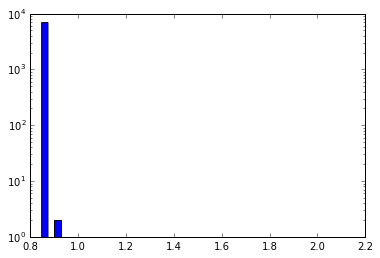

In [27]:
import matplotlib.pyplot as plt
plt.yscale('log', nonposy='clip')
plt.hist([j-i for i, j in zip(times[:-1], times[1:])], 50)

In [23]:
cross_entropy_times = times

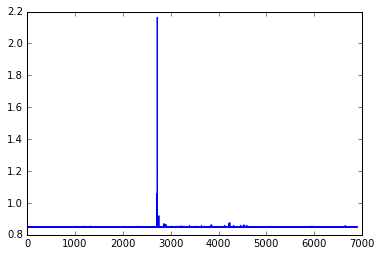

In [26]:
#plt.yscale('log', nonposy='clip')
plt.plot([j-i for i, j in zip(times[:-1], times[1:])])

In [26]:
import pickle
with open('cross_entropy.pickle', 'wb') as handle:
    pickle.dump(cross_entropy_times, handle)

In [11]:
# Helper functions for defining networks
def weight_variable(shape, wd):
    initial = tf.truncated_normal(shape, stddev=0.01)
    weight_decay = tf.mul(tf.nn.l2_loss(initial), wd)
    tf.add_to_collection('losses', weight_decay)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [12]:
# Need to implement image resizing!!! (and maybe also various augmentations)
# Bring from 0, 255 to 0, 1
# Subtract mean
# Then, bounding boxes will need re-scaled also..

# Mostly, but not completely, done. Also, image means might be slightly wrong due to BGR vs RGB ordering

In [13]:
# Something like Alexnet
sess = tf.InteractiveSession()

# Batched input
#x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, image_depth], name="Input_Image_Batch") # batch size, image size, image size, image depth
#y_ = tf.placeholder(tf.float32, shape=[None, num_classes], name="Input_Classes") # batch size, num_classes

x = tf.placeholder(tf.float32, shape=[None, image_size, image_size, image_depth], name="Input_Image_Batch") # batch size, image size, image size, image depth
y_ = tf.placeholder(tf.int32, shape=[None], name="Class") # batch size, num_classes


# ALL MAX POOLING LAYERS SHOULD HAVE SIZE 3x3 and stride 2

# First Convolutional Layer
# Variables
W_conv1 = weight_variable([11, 11, image_depth, 96], wd=0.0) # filter size, filter size, input channels (image depth), output channels
b_conv1 = bias_variable([96])
# Layers
h_conv1 = tf.nn.relu(conv2d(x, W_conv1, stride=4) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Convolutional Layer
# Variables
W_conv2 = weight_variable([5, 5, 96, 256], wd=0.0)
b_conv2 = bias_variable([256])
# Layers
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, stride=1) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Third Convolutional Layer
# Variables
W_conv3 = weight_variable([3, 3, 256, 384], wd=0.0)
b_conv3 = bias_variable([384])
# Layers
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3, stride=1) + b_conv3)

# Fourth Convolutional Layer
# Variables
W_conv4 = weight_variable([3, 3, 384, 384], wd=0.0)
b_conv4 = bias_variable([384])
# Layers
h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, stride=1) + b_conv4)

# Fifth Convolutional Layer
# Variables
W_conv5 = weight_variable([3, 3, 384, 256], wd=0.0)
b_conv5 = bias_variable([256])
# Layers
h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, stride=1) + b_conv5)
h_pool5 = max_pool_2x2(h_conv5)

# Fully Connected 1
# Weights
W_fc1 = weight_variable([int(image_size/32) * int(image_size/32) * 256, 4096], wd=0.004)
b_fc1 = bias_variable([4096])
# Layers
h_pool5_flat = tf.reshape(h_pool5, [-1, int(image_size/32) * int(image_size/32) * 256])
h_fc1 = tf.nn.relu(tf.matmul(h_pool5_flat, W_fc1) + b_fc1)

# Fully Connected 2
# Weights
W_fc2 = weight_variable([4096, 4096], wd=0.004)
b_fc2 = bias_variable([4096])
# Layers
h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

# Softmax
# Weights
W_fc3 = weight_variable([4096, num_classes], wd=0.0)
b_fc3 = bias_variable([num_classes])
# Layers
softmax_linear = tf.matmul(h_fc2, W_fc3) + b_fc3
y_conv=tf.nn.softmax(softmax_linear)

In [14]:
# Learning rate 
learning_rate = tf.placeholder(tf.float32)

In [15]:
# Loss function 
#cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
#cross_entropy = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(y_conv,1e-10,1.0))) # this fix was needed for some reason..

# NEED TO ADD WEIGHT DECAY TO THIS LOSS FUNCTION

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
      softmax_linear, tf.to_int64(y_), name='cross_entropy_per_example')
cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy_thingy')



# Optimization Algorithm
#train_step = tf.train.MomentumOptimizer(learning_rate, .9).minimize(cross_entropy)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_mean)
#train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Accuracy function
#correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
correct_prediction = tf.nn.in_top_k(y_conv, y_, 1)
accuracy = tf.reduce_sum(tf.cast(correct_prediction, tf.int32)) / batch_size

In [16]:
# Make summary of cross entropy loss
tf.scalar_summary("cross entropy", cross_entropy_mean)

# Make a summary of training accuracy
tf.scalar_summary("accuracy", accuracy)

# Learning rate summary
tf.scalar_summary("learning rate", learning_rate)

# Make a bunch of histogram summaries
tf.histogram_summary("image inputs", x)
tf.histogram_summary("class inputs", y_)
tf.histogram_summary("conv1_weights", W_conv1)
tf.histogram_summary("conv2_weights", W_conv2)
tf.histogram_summary("conv3_weights", W_conv3)
tf.histogram_summary("conv4_weights", W_conv4)
tf.histogram_summary("conv5_weights", W_conv5)
tf.histogram_summary("conv1_biases", b_conv1)
tf.histogram_summary("conv2_biases", b_conv2)
tf.histogram_summary("conv3_biases", b_conv3)
tf.histogram_summary("conv4_biases", b_conv4)
tf.histogram_summary("conv5_biases", b_conv5)
tf.histogram_summary("fc1_weights", W_fc1)
tf.histogram_summary("fc1_biases", b_fc1)
tf.histogram_summary("fc2_weights", W_fc2)
tf.histogram_summary("fc2_biases", b_fc2)
tf.histogram_summary("conv1_outputs", h_conv1)
tf.histogram_summary("conv2_outputs", h_conv2)
tf.histogram_summary("conv3_outputs", h_conv3)
tf.histogram_summary("conv4_outputs", h_conv4)
tf.histogram_summary("conv5_outputs", h_conv5)
tf.histogram_summary("fc1_outputs", h_fc1)
tf.histogram_summary("fc2_outputs", h_fc2)
tf.histogram_summary("pool5_outputs", h_pool5)
tf.histogram_summary("final_predictions", y_conv)

# Merge all the summaries and write them out to /tmp/mnist_logs
merged = tf.merge_all_summaries()

In [17]:
#train_step.run(feed_dict={learning_rate: learning_rate_value})

In [18]:
# Fix log directory name

In [19]:
sess.run([enqueue_filenames])
tf.train.start_queue_runners(sess=sess)

[<Thread(Thread-3, started daemon 140117833848576)>,
 <Thread(Thread-4, started daemon 140117825455872)>,
 <Thread(Thread-5, started daemon 140117817063168)>,
 <Thread(Thread-6, started daemon 140117808670464)>,
 <Thread(Thread-7, started daemon 140117142374144)>,
 <Thread(Thread-8, started daemon 140117118297856)>,
 <Thread(Thread-9, started daemon 140117109905152)>,
 <Thread(Thread-10, started daemon 140117101512448)>,
 <Thread(Thread-11, started daemon 140117085267712)>,
 <Thread(Thread-12, started daemon 140117076875008)>,
 <Thread(Thread-13, started daemon 140116530030336)>,
 <Thread(Thread-14, started daemon 140116521637632)>,
 <Thread(Thread-15, started daemon 140116513244928)>,
 <Thread(Thread-16, started daemon 140116504852224)>,
 <Thread(Thread-17, started daemon 140116496459520)>,
 <Thread(Thread-18, started daemon 140116488066816)>,
 <Thread(Thread-19, started daemon 140116479674112)>,
 <Thread(Thread-20, started daemon 140115322074880)>,
 <Thread(Thread-21, started daemon 

In [20]:
sess.run(tf.initialize_all_variables())

i = 0

In [21]:

save_name = "imagenet_11"
writer = tf.train.SummaryWriter(home_dir + "projects/deep_learning/tensorflow/tmp/alexnet_logs/"+save_name, sess.graph_def, flush_secs=10)
#saver = tf.train.Saver()

In [22]:
import time
last_time = time.time()

In [23]:
cross_entropy_mean_summary = tf.convert_to_tensor(cross_entropy_mean)

In [26]:
learning_rate_value = 1

while(True):
    i += 1
    if i%20 == 0:
        # Summary ops take about 2.5 seconds to run
        summary, cross_entropy_mean = sess.run([merged, cross_entropy_mean_summary], 
                    feed_dict={learning_rate: learning_rate_value})
        writer.add_summary(summary, i)
        print("cross_entropy_mean at step %s: %s" % (i, cross_entropy_mean))
        print("elapsed time: {}".format(time.time() - last_time))
        last_time = time.time()
    else:
        train_step.run(feed_dict={learning_rate: learning_rate_value})

cross_entropy_mean at step 1400: 6.92012
elapsed time: 28.149460792541504
cross_entropy_mean at step 1420: 6.90445
elapsed time: 20.613927841186523
cross_entropy_mean at step 1440: 6.9168
elapsed time: 21.103481769561768
cross_entropy_mean at step 1460: 6.90054
elapsed time: 32.108006715774536
cross_entropy_mean at step 1480: 6.90433
elapsed time: 50.92725419998169
cross_entropy_mean at step 1500: 6.90852
elapsed time: 60.56604051589966
cross_entropy_mean at step 1520: 6.91409
elapsed time: 82.34089994430542
cross_entropy_mean at step 1540: 6.90775
elapsed time: 25.701226711273193
cross_entropy_mean at step 1560: 6.90107
elapsed time: 131.3600254058838
cross_entropy_mean at step 1580: 6.90432
elapsed time: 86.55791425704956
cross_entropy_mean at step 1600: 6.90799
elapsed time: 93.08800482749939
cross_entropy_mean at step 1620: 6.90332
elapsed time: 100.36446499824524
cross_entropy_mean at step 1640: 6.91019
elapsed time: 116.34411191940308


KeyboardInterrupt: 

In [ ]:
# Save weights to file
# Could name with "i", the number of iterations progressed
save_number = 1
save_path = saver.save(sess, "tmp/checkpoints/{save_name}_{save_number}.ckpt".format(save_name=save_name, save_number=save_number))
print("Model saved in file: %s" % save_path)

In [ ]:
# Restore weights from file
#saver.restore(sess, "/tmp/model.ckpt")

In [ ]:
# TODOS
# Weight decay, batch normalization, bigger network, different filter sizes, inception filters
# sgd with momentum seems standard

In [11]:
# Helper functions to load dataset

def crop_resize_image(image, desired_dimension):
    width, height, depth = image.shape
    if width >= height:
        cropped_image = image[int(width / 2) - int(height/2):int(width / 2) + int(height/2),:,:]
    else:
        cropped_image = image[:,int(height / 2) - int(width/2):int(height / 2) + int(width/2),:]
    return cv2.resize(cropped_image, (desired_dimension, desired_dimension))

# Returns a [height, width, depth] image in RGB pixel order
def read_jpeg(filename):
    image = cv2.imread(imagenet_dir + "2012_train/{}".format(filename))
    if image is None:
        print("Failed to read image! This is probably bad")
    # Convert BGR to RGB. 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Subtract image means from all of imagenet. I think these are RGB, but might be BGR.....
    image = image - np.array([104, 116, 122])
    image = image / 255.0
    return  image

# Plots an image from either filename or numpy array. 
def show_image(image):
    if isinstance(image, str):
        image = read_jpeg(image)
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.imshow(image)

image_index = 0
# Gets a batch of images from a given list of filenames
def get_batch(filenames, num_images, img_size, num_classes):
    global image_index
    #shuffle(filenames)
    images = []
    classes = []
    if image_index > len(filenames) - 2 * num_images:
        print("Finished epoch, shuffling filenames!")
        shuffle(filenames)
        image_index = 0
    while len(images) < num_images:
        filename = filenames[image_index]
        image = read_jpeg(filename)
        image = crop_resize_image(image, img_size)
        images.append(image)
        classes.append(class_to_index[filename.split("_")[0]])
        image_index += 1
    return np.array(images), dense_to_one_hot(np.array(classes), num_classes)

def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def one_hot_to_class(one_hot):
    for key, value in enumerate(one_hot):
        if value > 0:
            return indexes_to_classes[key]